# 13 - Population Density Analysis

This notebook analyzes the relationship between population density and earthquake characteristics.

## Key Questions
- Is there a correlation between population density and earthquake frequency?
- How do earthquake characteristics (magnitude, depth) vary with population density?
- What is the seismic risk exposure based on population density?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os, sys, warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))
from config import *
from visualization import setup_style, create_turkey_basemap
setup_style()

OUTPUT_DIR = os.path.join(FIGURES_PATH, '13_population')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data
eq_df = pd.read_csv(os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv'))
eq_df['date'] = pd.to_datetime(eq_df['date'], format='mixed')

# Check if population density is available
if 'population_density' not in eq_df.columns:
    print("WARNING: population_density not found. Re-run notebook 01.")
else:
    print(f"Records with population density: {eq_df['population_density'].notna().sum():,}")
    print(f"Total records: {len(eq_df):,}")

Records with population density: 514,965
Total records: 524,952


## 1. Population Density Distribution

In [2]:
# Filter records with population data
eq_pop = eq_df[eq_df['population_density'].notna()].copy()

# Create population density bins
pop_bins = [0, 50, 100, 200, 500, 1000, 5000]
pop_labels = ['<50', '50-100', '100-200', '200-500', '500-1000', '>1000']
eq_pop['pop_density_bin'] = pd.cut(eq_pop['population_density'], bins=pop_bins, labels=pop_labels)

print("\nEarthquake distribution by population density:")
print(eq_pop['pop_density_bin'].value_counts().sort_index())


Earthquake distribution by population density:
pop_density_bin
<50          88646
50-100      279598
100-200      77918
200-500      65840
500-1000       294
>1000         2669
Name: count, dtype: int64


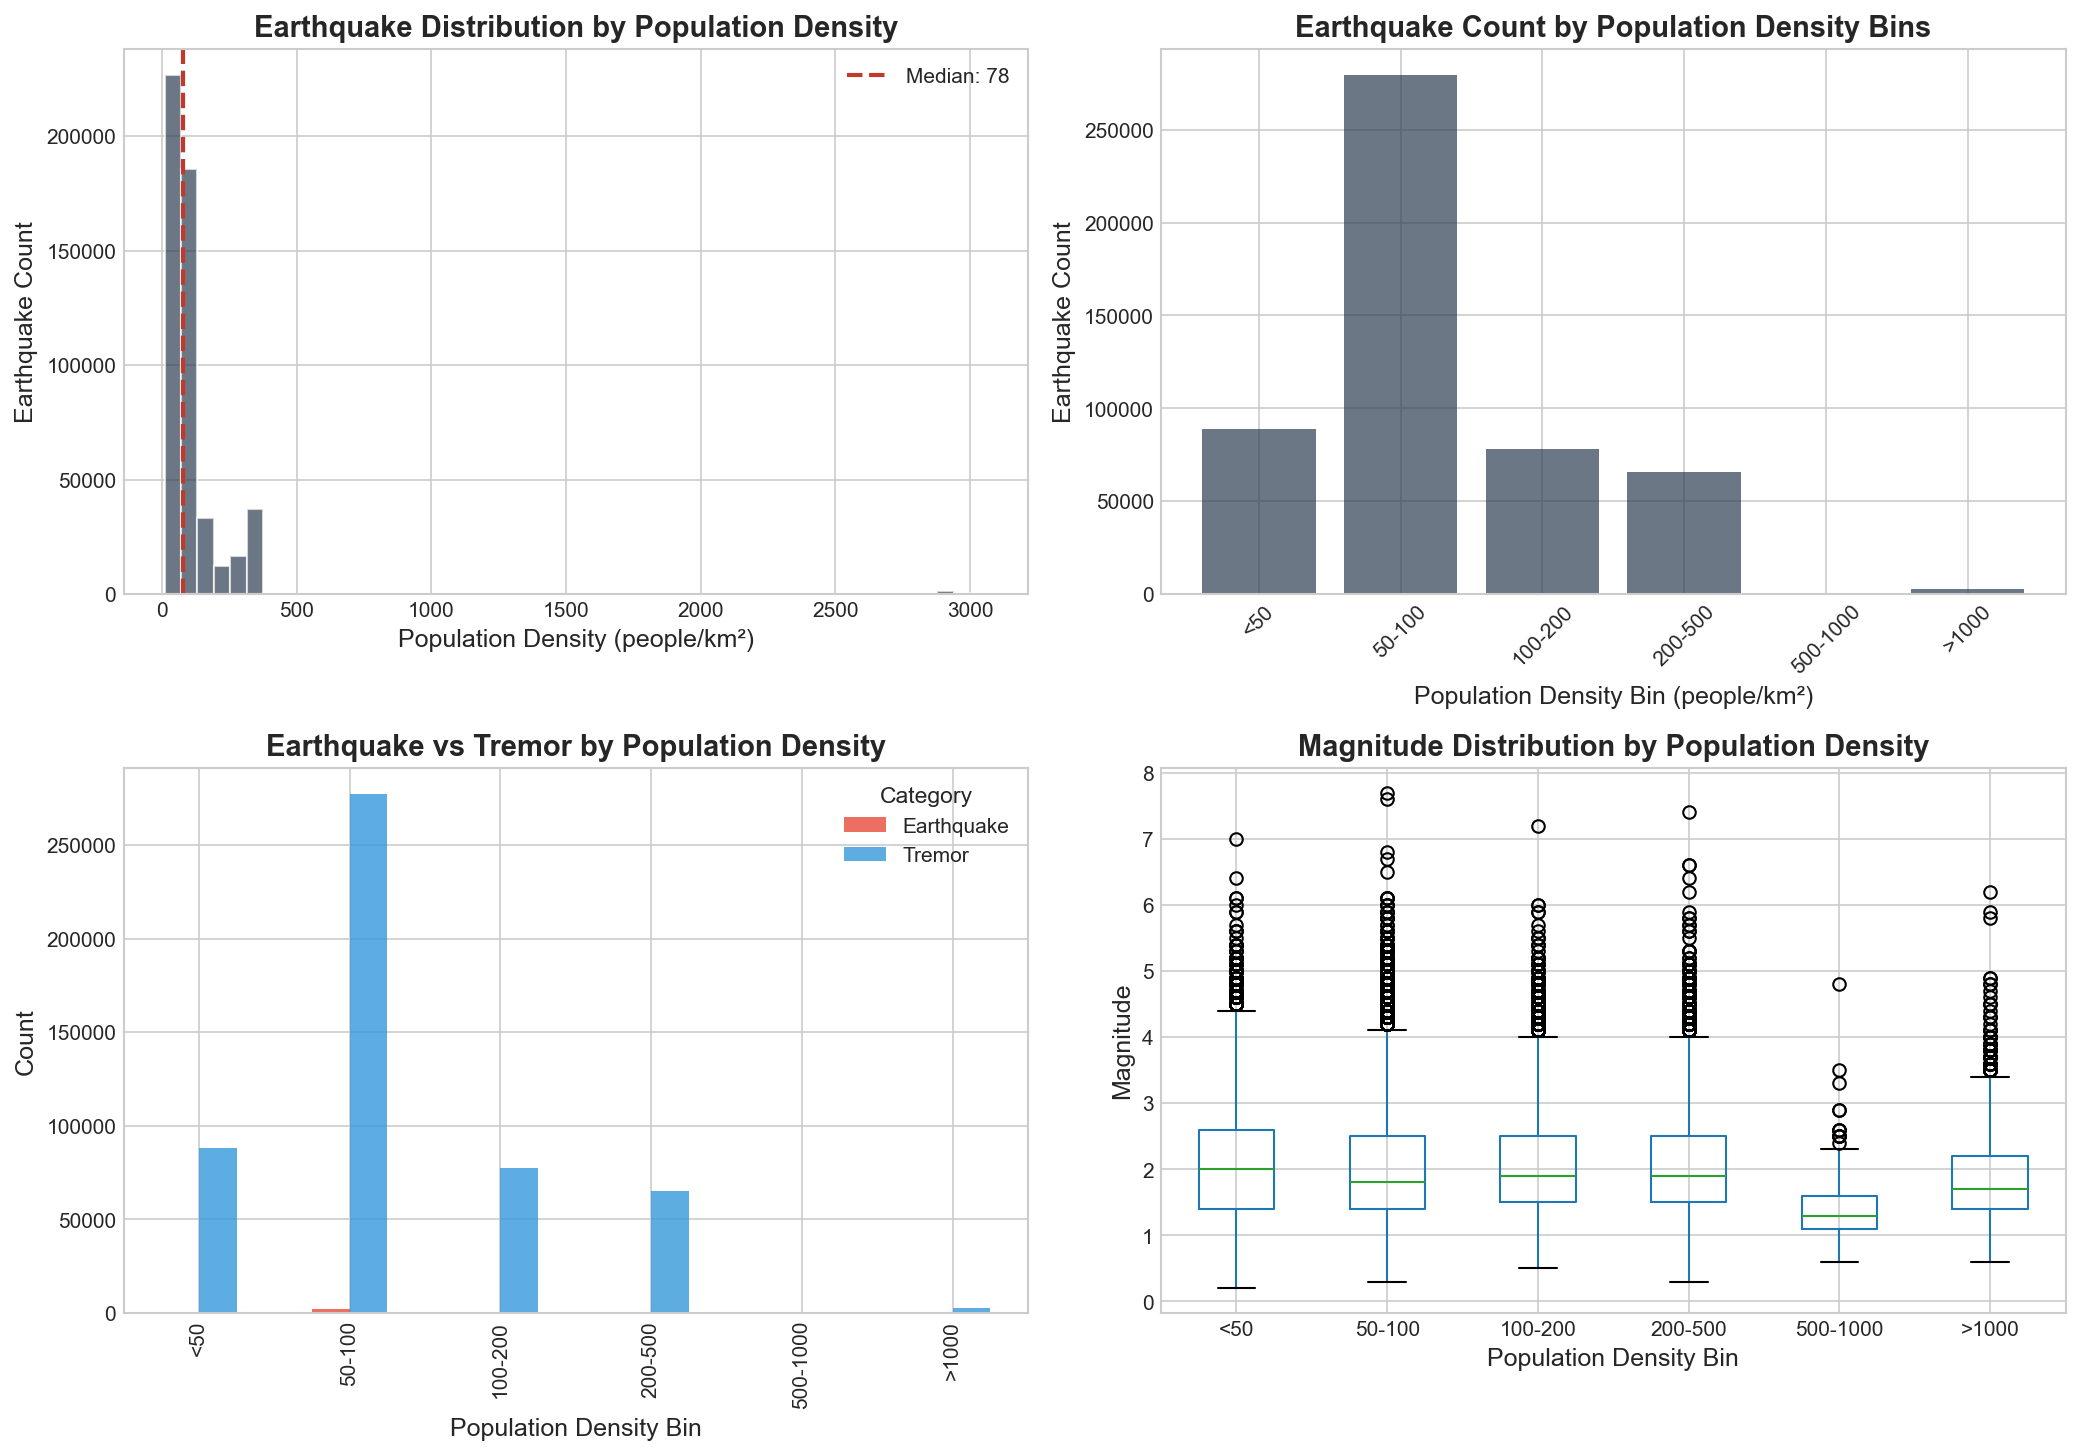

In [3]:
# Visualize distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Population density distribution of earthquakes
ax1 = axes[0, 0]
ax1.hist(eq_pop['population_density'], bins=50, color=COLORS['primary'], alpha=0.7, edgecolor='white')
ax1.axvline(eq_pop['population_density'].median(), color=COLORS['danger'], linestyle='--', 
            linewidth=2, label=f'Median: {eq_pop["population_density"].median():.0f}')
ax1.set_xlabel('Population Density (people/km²)')
ax1.set_ylabel('Earthquake Count')
ax1.set_title('Earthquake Distribution by Population Density', fontweight='bold')
ax1.legend()

# Bar plot by density bins
ax2 = axes[0, 1]
bin_counts = eq_pop['pop_density_bin'].value_counts().sort_index()
ax2.bar(range(len(bin_counts)), bin_counts.values, color=COLORS['primary'], alpha=0.7)
ax2.set_xticks(range(len(bin_counts)))
ax2.set_xticklabels(bin_counts.index, rotation=45)
ax2.set_xlabel('Population Density Bin (people/km²)')
ax2.set_ylabel('Earthquake Count')
ax2.set_title('Earthquake Count by Population Density Bins', fontweight='bold')

# Category distribution by pop density
ax3 = axes[1, 0]
cat_pop = eq_pop.groupby('pop_density_bin')['category'].value_counts().unstack(fill_value=0)
cat_pop.plot(kind='bar', ax=ax3, color=[COLORS['earthquake'], COLORS['tremor']], alpha=0.8)
ax3.set_xlabel('Population Density Bin')
ax3.set_ylabel('Count')
ax3.set_title('Earthquake vs Tremor by Population Density', fontweight='bold')
ax3.legend(title='Category')
plt.xticks(rotation=45)

# Magnitude distribution by pop density bin (boxplot)
ax4 = axes[1, 1]
eq_pop.boxplot(column='magnitude', by='pop_density_bin', ax=ax4)
ax4.set_xlabel('Population Density Bin')
ax4.set_ylabel('Magnitude')
ax4.set_title('Magnitude Distribution by Population Density', fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'population_density_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

## 2. Provincial Analysis

In [4]:
# Aggregate by province
province_stats = eq_pop.groupby('province').agg({
    'eventID': 'count',
    'magnitude': ['mean', 'max'],
    'population_density': 'mean',
    'depth': 'mean'
}).round(2)
province_stats.columns = ['eq_count', 'mag_mean', 'mag_max', 'pop_density', 'depth_mean']
province_stats = province_stats.reset_index()

# Filter for M >= 4.0 earthquakes
earthquakes = eq_pop[eq_pop['category'] == 'Earthquake']
province_eq_count = earthquakes.groupby('province').size().reset_index(name='significant_eq_count')

province_stats = province_stats.merge(province_eq_count, on='province', how='left')
province_stats['significant_eq_count'] = province_stats['significant_eq_count'].fillna(0).astype(int)

print("Top 15 provinces by earthquake count:")
province_stats.sort_values('eq_count', ascending=False).head(15)

Top 15 provinces by earthquake count:


,province,eq_count,mag_mean,mag_max,pop_density,depth_mean,significant_eq_count
53,Muğla,62335,2.00,6.5,73.25,9.30,577
78,İzmir,37572,2.05,6.6,351.01,7.78,254
49,Malatya,37361,1.74,5.9,64.15,7.67,253
36,Kahramanmaraş,32720,1.94,7.7,77.89,7.57,354
11,Balıkesir,31996,1.77,6.1,87.55,7.64,141
50,Manisa,24986,1.88,5.5,107.53,7.62,90
45,Kütahya,24732,2.03,5.4,48.33,7.89,64
70,Van,21480,2.40,6.7,55.21,8.04,290
74,Çanakkale,19196,1.99,5.6,53.22,8.15,141
21,Denizli,17361,1.96,6.0,84.70,7.65,77


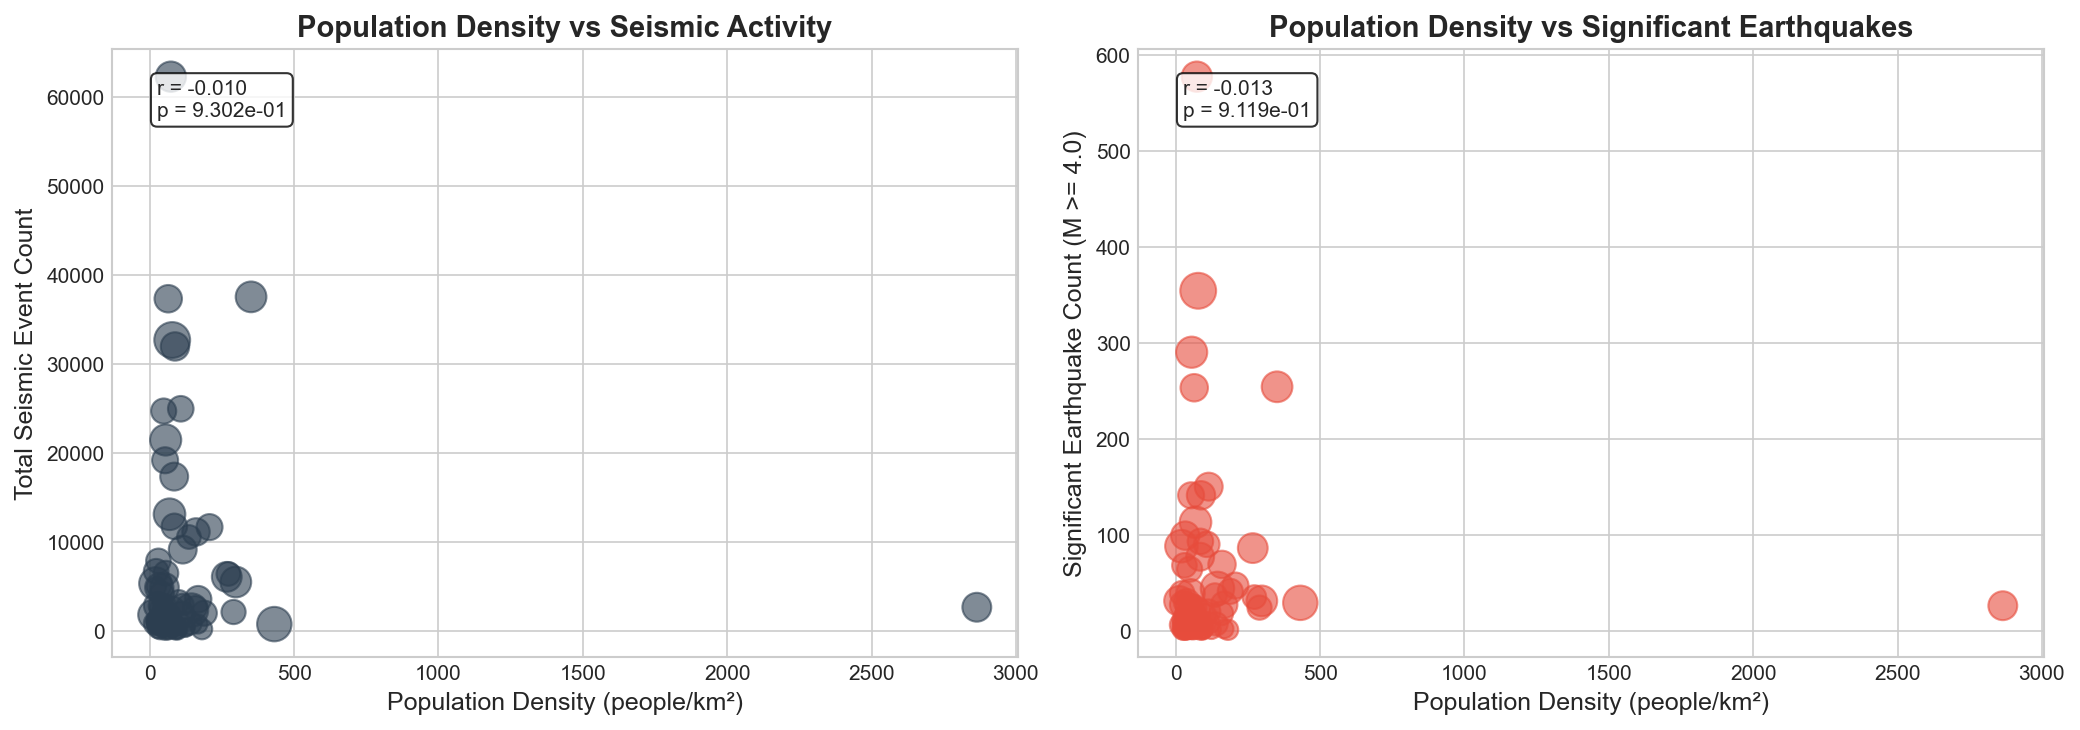

In [5]:
# Scatter plot: Population density vs Earthquake count
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# All seismic events
ax1 = axes[0]
ax1.scatter(province_stats['pop_density'], province_stats['eq_count'], 
            s=province_stats['mag_max']**2 * 5, alpha=0.6, c=COLORS['primary'])
ax1.set_xlabel('Population Density (people/km²)')
ax1.set_ylabel('Total Seismic Event Count')
ax1.set_title('Population Density vs Seismic Activity', fontweight='bold')

# Add correlation
r, p = stats.pearsonr(province_stats['pop_density'], province_stats['eq_count'])
ax1.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3e}', transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Significant earthquakes only
ax2 = axes[1]
significant_provinces = province_stats[province_stats['significant_eq_count'] > 0]
ax2.scatter(significant_provinces['pop_density'], significant_provinces['significant_eq_count'],
            s=significant_provinces['mag_max']**2 * 5, alpha=0.6, c=COLORS['earthquake'])
ax2.set_xlabel('Population Density (people/km²)')
ax2.set_ylabel('Significant Earthquake Count (M >= 4.0)')
ax2.set_title('Population Density vs Significant Earthquakes', fontweight='bold')

# Add correlation
r2, p2 = stats.pearsonr(significant_provinces['pop_density'], significant_provinces['significant_eq_count'])
ax2.text(0.05, 0.95, f'r = {r2:.3f}\np = {p2:.3e}', transform=ax2.transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'province_correlation.png'), dpi=150, bbox_inches='tight')
plt.show()

## 3. Risk Exposure Analysis

In [6]:
# Calculate risk exposure: population density * earthquake energy
earthquakes_only = eq_pop[eq_pop['category'] == 'Earthquake'].copy()

# Risk exposure per province
province_risk = earthquakes_only.groupby('province').agg({
    'energy_joules': 'sum',
    'population_density': 'mean',
    'eventID': 'count',
    'magnitude': 'max'
}).reset_index()
province_risk.columns = ['province', 'total_energy', 'pop_density', 'eq_count', 'max_mag']

# Calculate risk score (normalized)
province_risk['energy_normalized'] = province_risk['total_energy'] / province_risk['total_energy'].max()
province_risk['pop_normalized'] = province_risk['pop_density'] / province_risk['pop_density'].max()
province_risk['risk_score'] = province_risk['energy_normalized'] * province_risk['pop_normalized']

# Sort by risk
province_risk = province_risk.sort_values('risk_score', ascending=False)

print("Top 15 highest risk provinces (combined energy × population density):")
province_risk[['province', 'eq_count', 'max_mag', 'pop_density', 'risk_score']].head(15)

Top 15 highest risk provinces (combined energy × population density):


,province,eq_count,max_mag,pop_density,risk_score
33,Kahramanmaraş,354,7.7,77.423164,0.029781
39,Kocaeli,29,7.4,341.868966,0.027354
71,İstanbul,26,6.2,2599.761538,0.005485
21,Düzce,44,7.2,128.527273,0.005210
72,İzmir,254,6.6,324.614961,0.002704
27,Gaziantep,31,6.6,304.229032,0.001638
30,Hatay,86,6.4,263.904651,0.000826
23,Elazığ,113,6.8,66.503540,0.000742
48,Muğla,577,6.5,74.396014,0.000623
64,Van,290,6.7,53.858966,0.000494


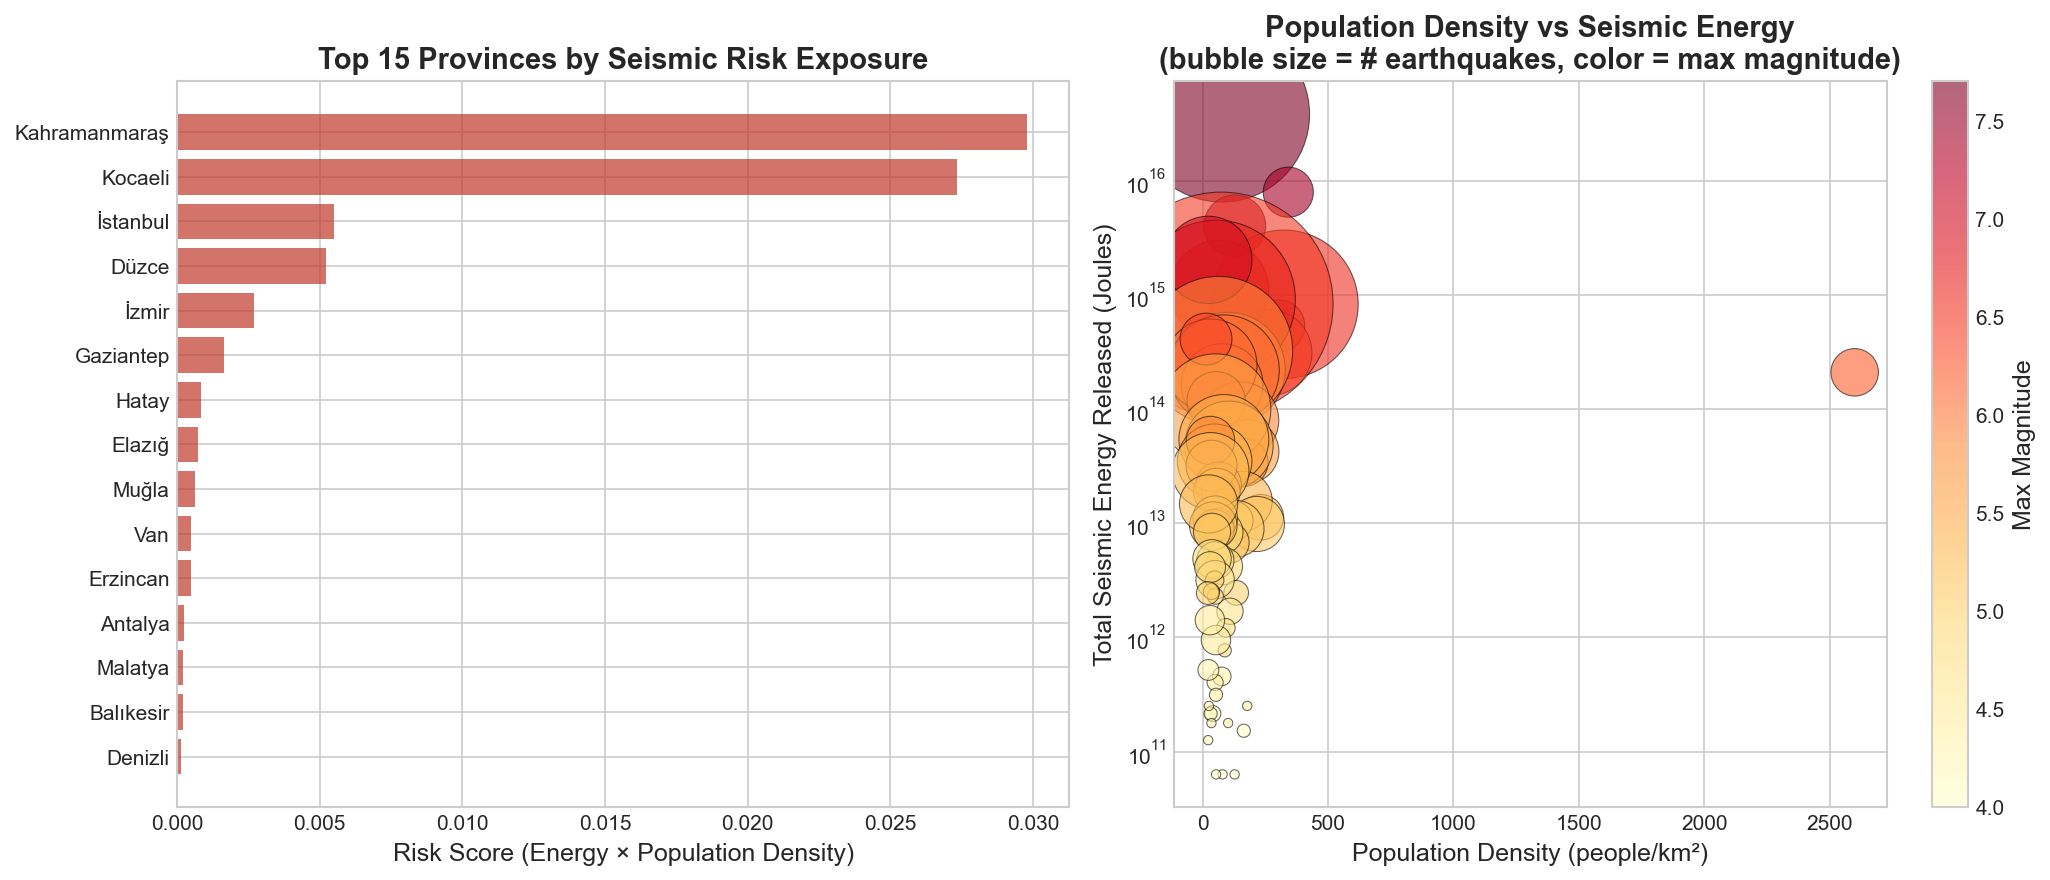

In [7]:
# Visualize risk
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top 15 by risk score
ax1 = axes[0]
top_risk = province_risk.head(15)
ax1.barh(range(len(top_risk)), top_risk['risk_score'], color=COLORS['danger'], alpha=0.7)
ax1.set_yticks(range(len(top_risk)))
ax1.set_yticklabels(top_risk['province'])
ax1.set_xlabel('Risk Score (Energy × Population Density)')
ax1.set_title('Top 15 Provinces by Seismic Risk Exposure', fontweight='bold')
ax1.invert_yaxis()

# Bubble chart
ax2 = axes[1]
scatter = ax2.scatter(province_risk['pop_density'], province_risk['total_energy'],
                      s=province_risk['eq_count'] * 20, c=province_risk['max_mag'],
                      cmap='YlOrRd', alpha=0.6, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('Population Density (people/km²)')
ax2.set_ylabel('Total Seismic Energy Released (Joules)')
ax2.set_title('Population Density vs Seismic Energy\n(bubble size = # earthquakes, color = max magnitude)', fontweight='bold')
ax2.set_yscale('log')
plt.colorbar(scatter, ax=ax2, label='Max Magnitude')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'risk_exposure.png'), dpi=150, bbox_inches='tight')
plt.show()

## 4. Statistical Tests

In [8]:
# Correlation analysis
print("Correlation Analysis")
print("=" * 60)

# Pearson correlation
r_mag, p_mag = stats.pearsonr(eq_pop['population_density'], eq_pop['magnitude'])
print(f"\nPopulation Density vs Magnitude:")
print(f"  Pearson r = {r_mag:.4f}, p-value = {p_mag:.4e}")

r_depth, p_depth = stats.pearsonr(eq_pop['population_density'], eq_pop['depth'])
print(f"\nPopulation Density vs Depth:")
print(f"  Pearson r = {r_depth:.4f}, p-value = {p_depth:.4e}")

Correlation Analysis

Population Density vs Magnitude:
  Pearson r = -0.0103, p-value = 1.8497e-13

Population Density vs Depth:
  Pearson r = -0.0069, p-value = 7.2381e-07


In [9]:
# ANOVA: Magnitude by population density bins
groups = [eq_pop[eq_pop['pop_density_bin'] == label]['magnitude'].values 
          for label in pop_labels if label in eq_pop['pop_density_bin'].values]

f_stat, p_value = stats.f_oneway(*groups)
print("\nANOVA Test (Magnitude by Population Density Bins):")
print(f"  F-statistic = {f_stat:.4f}")
print(f"  p-value = {p_value:.4e}")
print(f"  Result: {'Significant' if p_value < 0.05 else 'No significant'} difference (α=0.05)")


ANOVA Test (Magnitude by Population Density Bins):
  F-statistic = 423.0936
  p-value = 0.0000e+00
  Result: Significant difference (α=0.05)


In [10]:
# Chi-square test: Category vs Population density bin
contingency = pd.crosstab(eq_pop['pop_density_bin'], eq_pop['category'])
chi2, p_val, dof, expected = stats.chi2_contingency(contingency)

print("\nChi-square Test (Category vs Population Density Bins):")
print(f"  Chi² = {chi2:.4f}")
print(f"  p-value = {p_val:.4e}")
print(f"  Degrees of freedom = {dof}")
print(f"  Result: {'Dependent' if p_val < 0.05 else 'Independent'} (α=0.05)")


Chi-square Test (Category vs Population Density Bins):
  Chi² = 35.4028
  p-value = 1.2503e-06
  Degrees of freedom = 5
  Result: Dependent (α=0.05)


## 5. Temporal Analysis

In [11]:
# Load population data for temporal trends
population_df = pd.read_excel(POPULATION_DATA, skiprows=1)
population_df.columns = ['year', 'province', 'population_density']
population_df['year'] = pd.to_numeric(population_df['year'], errors='coerce')
population_df['population_density'] = pd.to_numeric(population_df['population_density'], errors='coerce')

# Turkey average population density over time
turkey_avg_pop = population_df.groupby('year')['population_density'].mean().reset_index()
turkey_avg_pop = turkey_avg_pop[turkey_avg_pop['year'] >= 1990]

# Earthquake count over time
yearly_eq = eq_pop[eq_pop['category'] == 'Earthquake'].groupby('year').size().reset_index(name='eq_count')

# Merge
temporal_data = turkey_avg_pop.merge(yearly_eq, on='year', how='left')
temporal_data['eq_count'] = temporal_data['eq_count'].fillna(0)

print("Temporal data shape:", temporal_data.shape)
temporal_data.head(10)

Temporal data shape: (20, 3)


,year,population_density,eq_count
0,1990,85.000000,39
1,2000,104.790123,47
2,2007,111.150617,76
3,2008,112.797531,69
4,2009,114.445679,58
5,2010,116.279012,85
6,2011,117.969136,222
7,2012,119.466667,165
8,2013,121.290123,95
9,2014,122.913580,101


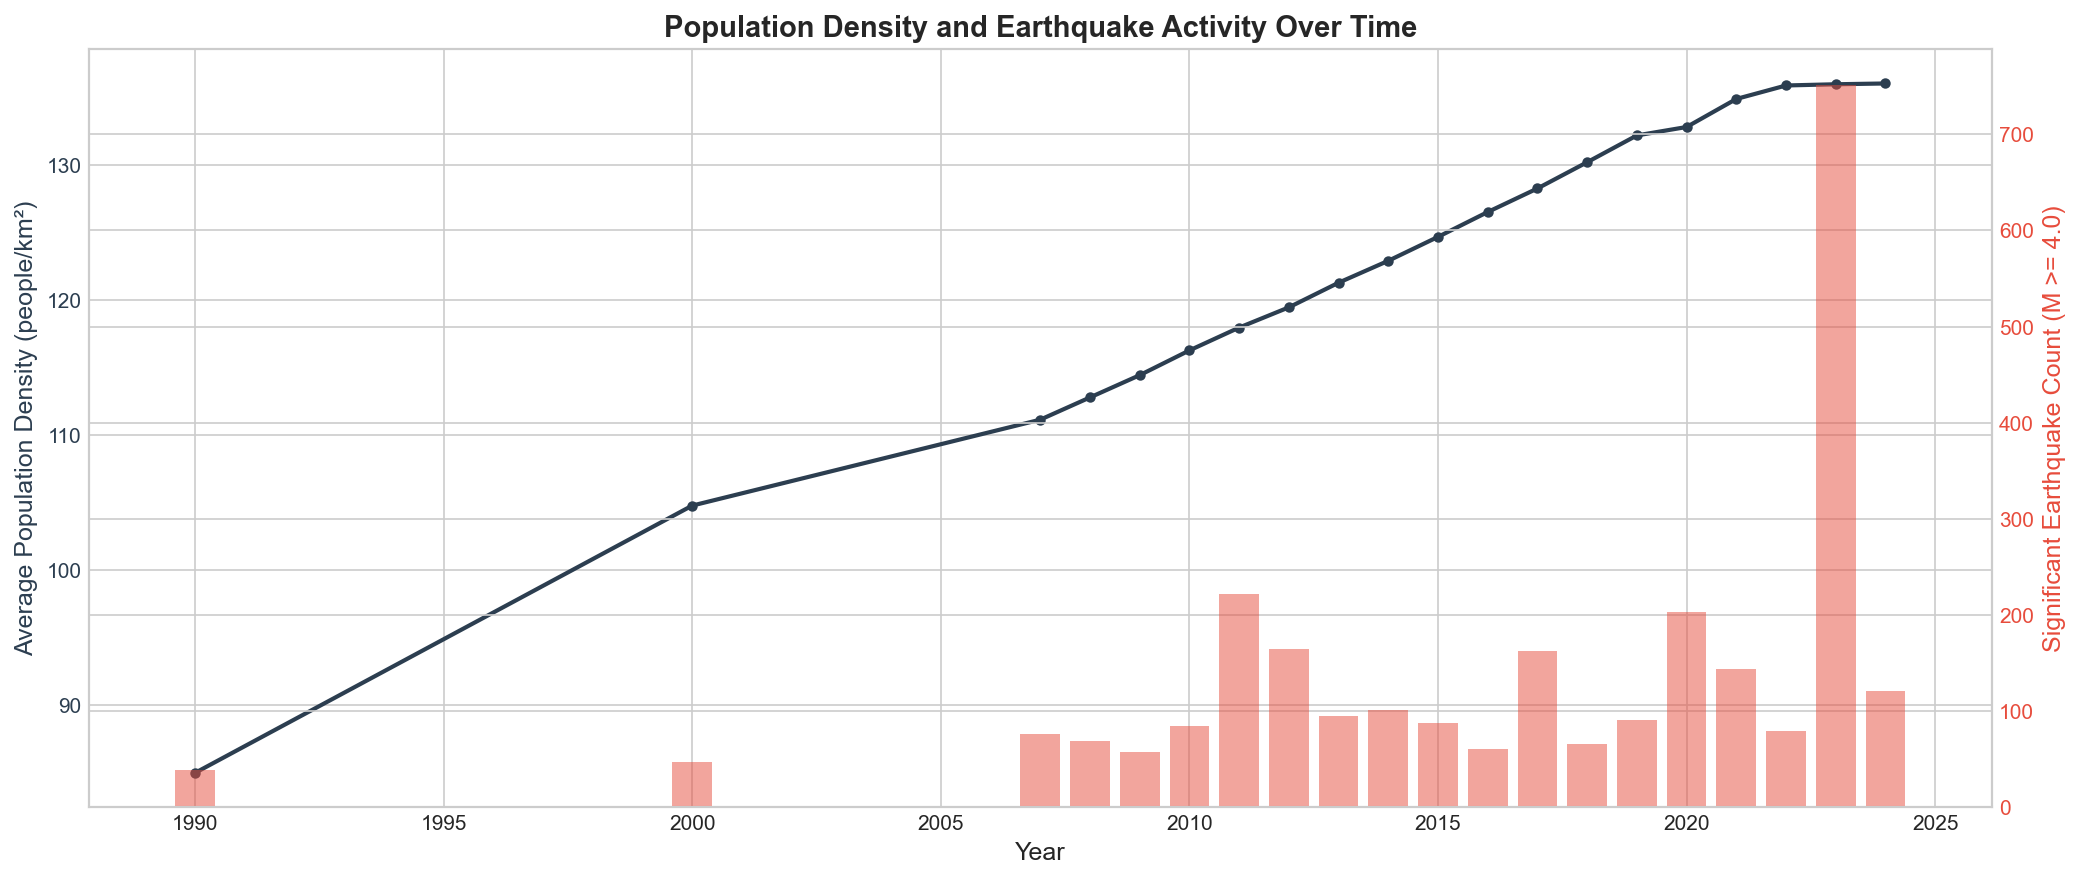

In [12]:
# Dual axis plot
fig, ax1 = plt.subplots(figsize=(14, 6))

color1 = COLORS['primary']
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Population Density (people/km²)', color=color1)
ax1.plot(temporal_data['year'], temporal_data['population_density'], 
         color=color1, linewidth=2, marker='o', markersize=4, label='Population Density')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = COLORS['earthquake']
ax2.set_ylabel('Significant Earthquake Count (M >= 4.0)', color=color2)
ax2.bar(temporal_data['year'], temporal_data['eq_count'], 
        color=color2, alpha=0.5, label='Earthquakes')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Population Density and Earthquake Activity Over Time', fontweight='bold', fontsize=14)
fig.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'temporal_trends.png'), dpi=150, bbox_inches='tight')
plt.show()

## 6. Map Visualization

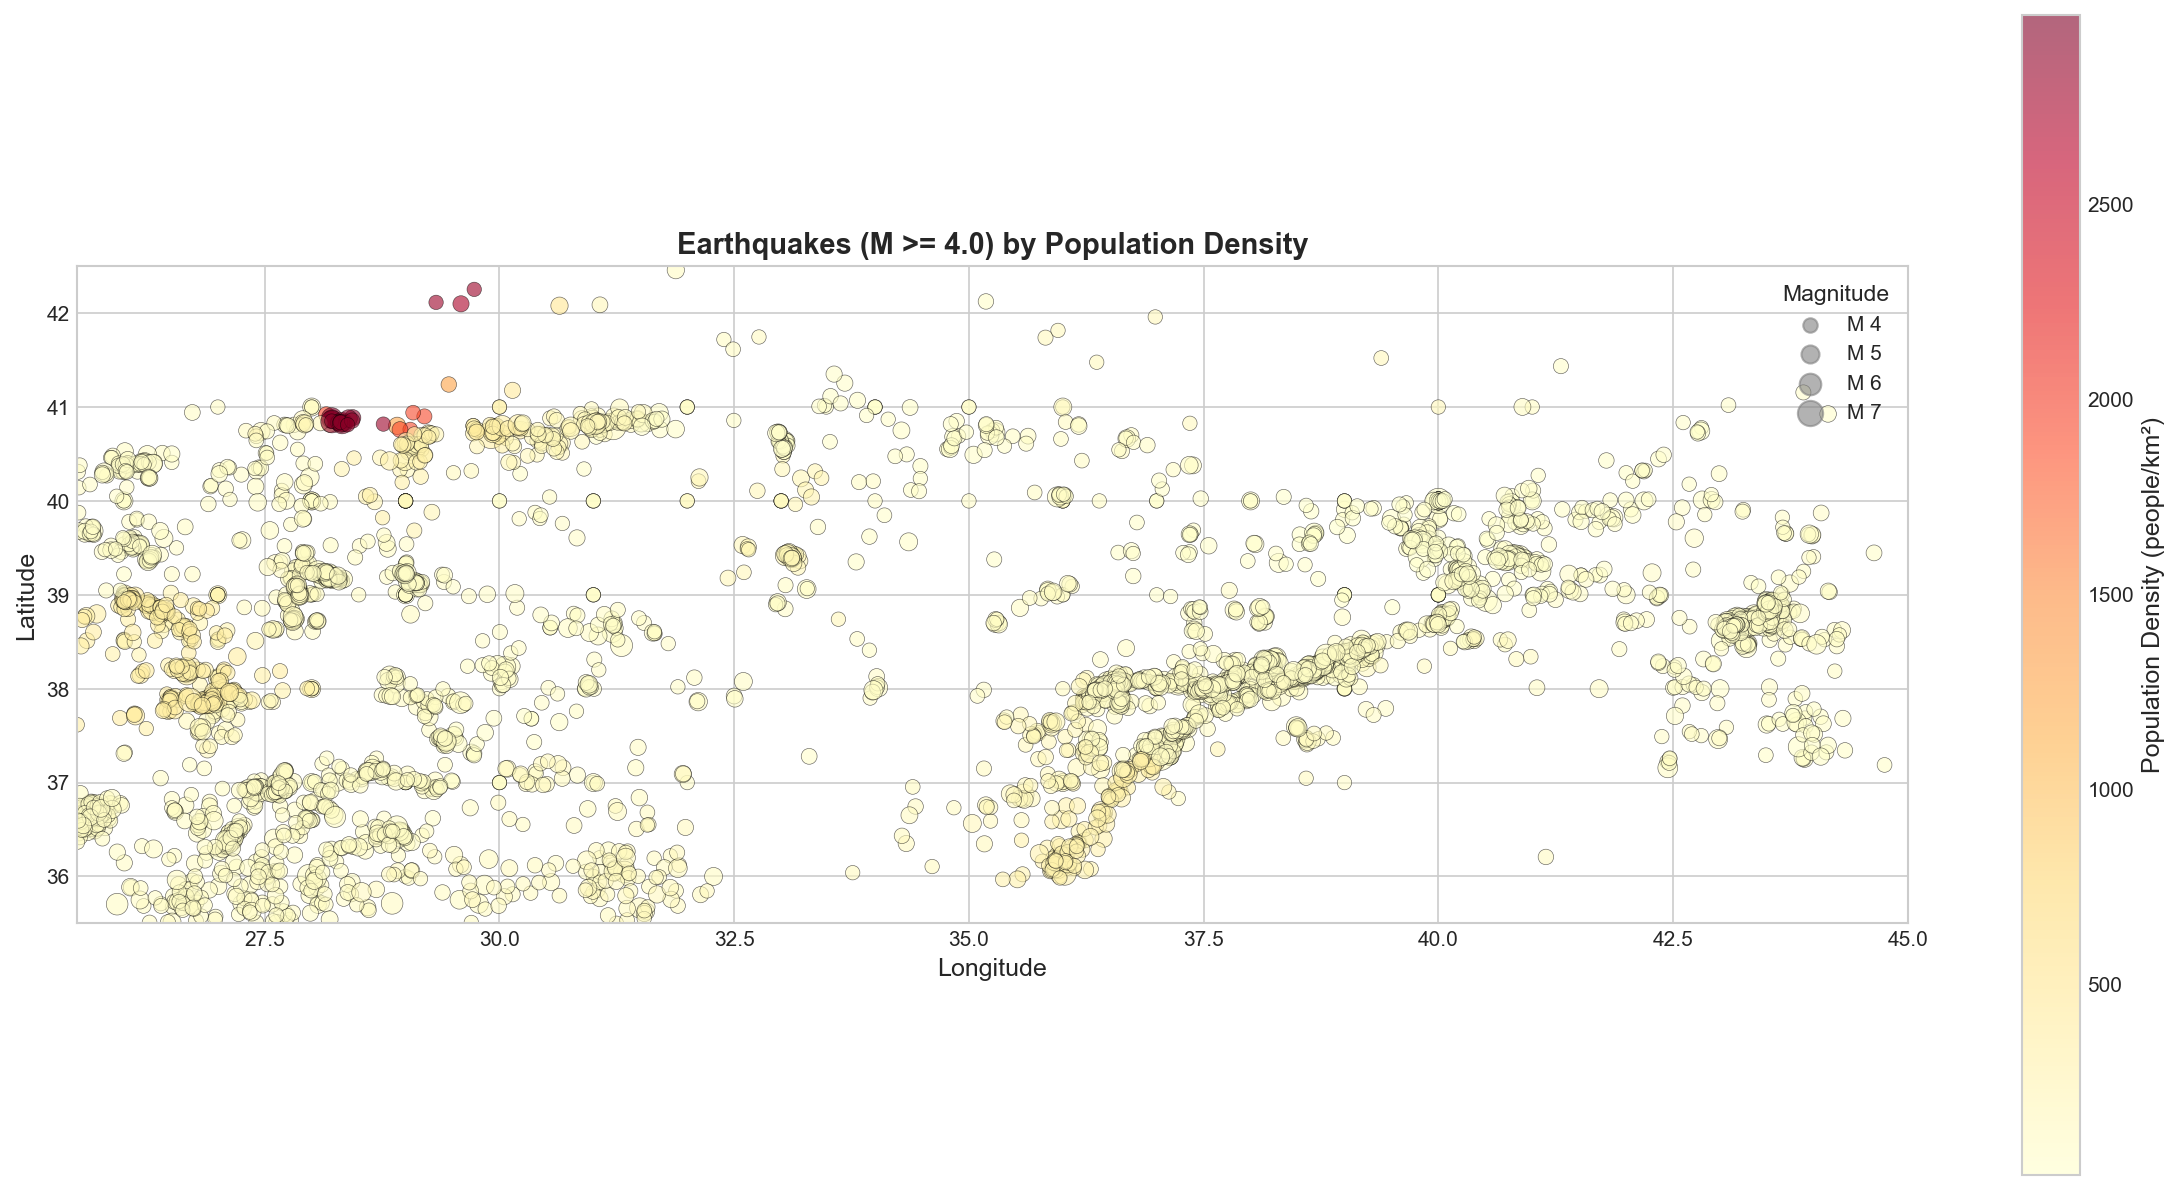

In [13]:
# Map of earthquakes colored by population density
fig, ax = plt.subplots(figsize=(16, 10))
ax = create_turkey_basemap(ax, 'Earthquakes (M >= 4.0) by Population Density')

# Plot earthquakes
eq_plot = earthquakes_only[earthquakes_only['population_density'].notna()]
scatter = ax.scatter(eq_plot['longitude'], eq_plot['latitude'],
                     c=eq_plot['population_density'], s=eq_plot['magnitude']**2 * 3,
                     cmap='YlOrRd', alpha=0.6, edgecolors='black', linewidth=0.3)

plt.colorbar(scatter, ax=ax, label='Population Density (people/km²)', shrink=0.8)

# Legend for size
for mag in [4, 5, 6, 7]:
    ax.scatter([], [], s=mag**2 * 3, c='gray', alpha=0.6, label=f'M {mag}')
ax.legend(title='Magnitude', loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'earthquake_map_population.png'), dpi=150, bbox_inches='tight')
plt.show()

## 7. Summary and Export

In [14]:
# Summary statistics by population density bin
summary_by_bin = eq_pop.groupby('pop_density_bin').agg({
    'eventID': 'count',
    'magnitude': ['mean', 'max'],
    'depth': 'mean',
    'energy_joules': 'sum'
}).round(2)
summary_by_bin.columns = ['count', 'mag_mean', 'mag_max', 'depth_mean', 'total_energy']

print("Summary by Population Density Bin:")
print(summary_by_bin)

# Save results
summary_by_bin.to_csv(os.path.join(TABLES_PATH, 'population_density_summary.csv'))
province_risk.to_csv(os.path.join(TABLES_PATH, 'province_risk_scores.csv'), index=False)

print(f"\nResults saved to:")
print(f"  - {os.path.join(TABLES_PATH, 'population_density_summary.csv')}")
print(f"  - {os.path.join(TABLES_PATH, 'province_risk_scores.csv')}")

Summary by Population Density Bin:
                  count  mag_mean  mag_max  depth_mean  total_energy
pop_density_bin                                                     
<50               88646      2.04      7.0        7.93  3.022506e+15
50-100           279598      1.94      7.7        8.14  4.264933e+16
100-200           77918      2.01      7.2        8.80  4.528216e+15
200-500           65840      2.00      7.4        7.77  9.746812e+15
500-1000            294      1.40      4.8        7.67  1.026170e+12
>1000              2669      1.90      6.2        8.10  2.126214e+14

Results saved to:
  - /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/population_density_summary.csv
  - /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/province_risk_scores.csv


In [15]:
print("\n" + "=" * 70)
print("POPULATION DENSITY ANALYSIS COMPLETE")
print("=" * 70)
print(f"\nKey Findings:")
print(f"  - Total earthquakes analyzed: {len(eq_pop):,}")
print(f"  - Correlation (pop density vs magnitude): r = {r_mag:.4f}")
print(f"  - Highest risk province: {province_risk.iloc[0]['province']}")
print(f"\nFigures saved to: {OUTPUT_DIR}")


POPULATION DENSITY ANALYSIS COMPLETE

Key Findings:
  - Total earthquakes analyzed: 514,965
  - Correlation (pop density vs magnitude): r = -0.0103
  - Highest risk province: Kahramanmaraş

Figures saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/figures/13_population
